In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from typing import Literal

from src.geometry import derive_metric_homography, compute_distance_from_homography
from src.data import Template, Scene, MeasurementData, load_measurements_from_yaml
from src.matching import extract_features, match_descriptors, compute_homography
from src.rendering import WebVisualizer
from src.utils import load_calibration_json, load_rgb

## **Pipeline Steps**

### **Step 1**: Multi-template Matching

In [3]:
def template_match(
    scene: Scene,
    templates: list[Template],
    extract_method: Literal['SIFT', 'ORB'] = 'SIFT',
    match_method: Literal['BF', 'FLANN'] = 'BF',
    min_match_count: int = 10,
) -> dict:
    """
    Perform multi-template matching on a scene image for the given templates.

    Args:
        scene (Scene): The scene object containing the image and metadata.
        templates (list[Template]): List of template objects to match against the scene.
        extract_method (Literal['SIFT', 'ORB']): Feature extraction method.
        match_method (Literal['BF', 'FLANN']): Feature matching method.
        min_match_count (int): Minimum number of matches required to consider a valid match.

    Returns:
        np.ndarray: The image size of the scene.
        dict: A dictionary containing, indexed by template id. For each template:
            - 'homography': The computed homography matrix.
            - 'error': The reprojection error.
    """
    # Initialize the results dictionary
    results = {}

    # Load the scene image
    scene_image = load_rgb(os.path.join(project_root, scene.path))

    # Extract its features and descriptors
    scene_keypoints, scene_descriptors = extract_features(scene_image, method=extract_method)

    # Iterate over each template
    for template in templates:
        # Load the template image
        template_image = load_rgb(os.path.join(project_root, template.path))

        # Extract features and descriptors from the template
        template_keypoints, template_descriptors = extract_features(template_image, method=extract_method)

        # Match the descriptors between the scene and the template
        matches = match_descriptors(template_descriptors, scene_descriptors, method=match_method)

        # Check if enough matches are found
        if len(matches) <= min_match_count:
            print(f"Not enough matches found for template {template.id}.")
            continue
            
        # Compute the homography
        H_px, mask, error = compute_homography(template_keypoints, scene_keypoints, matches)

        # Derive the metric homography
        H_metric = derive_metric_homography(
            H_px=H_px,
            template_size_px=template_image.shape[:2],
            template_size_metric=(template.height, template.width),
        )

        # Remove the scene keypoints that were used as inliers in the homography computation
        inlier_indices = set()
        for i, match in enumerate(matches):
            if mask[i] == 1:  # This match was an inlier
                inlier_indices.add(match.queryIdx)  # queryIdx is the scene keypoint index

        # Keep only the keypoints that weren't used as inliers
        remaining_indices = [i for i in range(len(scene_keypoints)) if i not in inlier_indices]
        scene_keypoints = [scene_keypoints[i] for i in remaining_indices]
        scene_descriptors = scene_descriptors[remaining_indices]

        # Store the results
        results[template.id] = {
            'homography': H_metric,
            'error': error
        }
    
    return scene_image.shape[:2], results

### **Step 2**: Camera Calibration

In [4]:
class CalibrationSimple:
    """
    Adapted Zhang's camera calibration method for estimating intrinsic parameters
    from homographies between multiple planar templates in a single scene.
    This version assumes zero skew (s = 0), known principal point (cx, cy), and
    square pixels (fx = fy).
    """
    
    def __init__(self):
        self.intrinsic_matrix = None
        self.homographies = []
    
    def _build_v_ij(self, H: np.ndarray, i: int, j: int) -> np.ndarray:
        """
        Compute the vector v_ij used in the Zhang-style calibration constraint:
        v_ij = [h1i*h1j, h1i*h2j + h2i*h1j, h2i*h2j, h3i*h1j + h1i*h3j, h3i*h2j + h2i*h3j, h3i*h3j]
        
        Args:
            H: homography matrix (3x3)
            i, j: column indices for the constraint
            
        Returns:
            v_ij: constraint vector (6,)
        """
        h = H.T  # transpose to access columns easily
        return np.array([
            h[i, 0] * h[j, 0],
            h[i, 0] * h[j, 1] + h[i, 1] * h[j, 0],
            h[i, 1] * h[j, 1],
            h[i, 0] * h[j, 2] + h[i, 2] * h[j, 0],
            h[i, 1] * h[j, 2] + h[i, 2] * h[j, 1],
            h[i, 2] * h[j, 2]
        ])
    
    def add_homography(self, H: np.ndarray):
        """
        Add a homography to the calibration dataset.
        
        Args:
            H: homography matrix (3x3)
        """
        if H.shape != (3, 3):
            raise ValueError("Homography must be a 3x3 matrix")
        self.homographies.append(H.copy())
    
    def add_homographies(self, Hs: list[np.ndarray]):
        """
        Add multiple homographies to the calibration dataset.
        
        Args:
            Hs: list of homography matrices (each 3x3)
        """
        for H in Hs:
            self.add_homography(H)
    
    def calibrate(self, principal_point=None) -> np.ndarray:
        """
        Estimate the intrinsic matrix K from the stored homographies.
        
        Args:
            principal_point: tuple (cx, cy) if known, otherwise assumes image center
            
        Returns:
            K: intrinsic matrix (3x3)
            
        Raises:
            ValueError: if fewer than 1 homography is available (since we have more constraints)
        """
        if len(self.homographies) < 1:  # Need fewer homographies now
            raise ValueError("At least 1 homography is required for calibration with known constraints")
        
        # Set principal point (default to image center if not provided)
        if principal_point is None:
            raise ValueError("Principal point (cx, cy) must be provided")
        else:
            cx, cy = principal_point
        
        V = []

        # Constraint 1: Zero skew (B12 = 0)
        V.append([0, 1, 0, 0, 0, 0])
        
        # Constraint 2: Square pixels (B11 = B22, so B11 - B22 = 0)
        V.append([1, 0, -1, 0, 0, 0])
        
        # Constraint 3: Known cx (B13 = -cx * B11)
        # This gives us: B13 + cx * B11 = 0
        V.append([cx, 0, 0, 1, 0, 0])
        
        # Constraint 4: Known cy (B23 = -cy * B22 = -cy * B11 since B11 = B22)
        # This gives us: B23 + cy * B11 = 0  
        V.append([cy, 0, 0, 0, 1, 0])

        # Add constraints from homographies (you might need fewer now)
        for H in self.homographies:
            H_norm = H / H[2, 2]  # Normalize
            v12 = self._build_v_ij(H_norm, 0, 1)  # v_12
            v11 = self._build_v_ij(H_norm, 0, 0)  # v_11  
            v22 = self._build_v_ij(H_norm, 1, 1)  # v_22
            
            V.append(v12)
            V.append(v11 - v22)
            
        V = np.vstack(V)
        
        # Solve Vb = 0 using SVD
        _, _, Vh = np.linalg.svd(V)
        b = Vh[-1, :]  # last row corresponds to smallest singular value

        # b = [B11, B12, B22, B13, B23, B33]
        B11, B12, B22, B13, B23, B33 = b
        
        # Simplified parameter extraction
        # Since B11 = B22, B12 = 0, B13 = -cx*B11, B23 = -cy*B11
        
        # The focal length f (since fx = fy = f)
        scale = B33 + cx * B13 + cy * B23  # This should equal B33 - cx²*B11 - cy²*B11
        f = np.sqrt(scale / B11)
        
        # Construct the intrinsic matrix
        K = np.array([
            [f,  0, cx],
            [0,  f, cy], 
            [0,  0,  1]
        ])
        
        self.intrinsic_matrix = K
        return K
    
    def get_intrinsic_matrix(self) -> np.ndarray:
        """
        Get the estimated intrinsic matrix.
        
        Returns:
            K: intrinsic matrix (3x3) or None if calibration hasn't been performed
        """
        return self.intrinsic_matrix
    
    def reset(self):
        """
        Clear all stored homographies and reset the calibration state.
        """
        self.homographies.clear()
        self.intrinsic_matrix = None
    
    def get_num_homographies(self) -> int:
        """
        Get the number of stored homographies.
        
        Returns:
            Number of homographies
        """
        return len(self.homographies)

In [5]:
def calibrate_camera(
    homographies: list[np.ndarray],
    image_size: np.ndarray
) -> np.ndarray:
    """
    Calibrate the camera using a set of homographies.
    For simplicity, only the focal length is estimated, based on the following assumptions:
    - zero skew
    - principal point at the image center
    - square pixels (fx = fy = f)

    Args:
        homographies (list[np.ndarray]): List of homographies.
        image_size (tuple[int, int]): Size of the image (height, width).
    
    Returns:
        np.ndarray: Estimated intrinsic camera matrix (3x3).
    """
    # Compute the principal point
    cx, cy = image_size[1] / 2, image_size[0] / 2

    # Initialize the calibration object
    calibration = CalibrationSimple()

    # Calibrate the camera
    calibration.add_homographies(homographies)
    return calibration.calibrate(principal_point=(cx, cy))

### **Step 3**: Intrinsics Refinement + Radial Distortion Estimation

In [6]:
def refine_calibration(
    templates: list[Template],
    homographies: list[np.ndarray],
    image_size: np.ndarray,
    K_init: np.ndarray,
    resolution: int = 20,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Refine the camera intrinsics and estimate radial distortion parameters (k1, k2).

    Args:
        templates (list[Template]): List of template objects containing metric dimensions.
        homographies (list[np.ndarray]): List of homographies for the scene.
        image_size (np.ndarray): Size of the image (width, height).
        K_init (np.ndarray): Initial intrinsic matrix (3x3).
        resolution (int): Resolution for the grid of points used for each template.

    Returns:
        tuple: Refined intrinsic matrix (3x3) and radial distortion parameters (1D array).
    """
    # Define the world points and the corresponding image points for each template
    object_points = []
    image_points = []
    for template, H in zip(templates, homographies):
        # Get template metric dimensions
        w, h = template.width, template.height

        # Define grid points on the template
        x = np.linspace(0, w, resolution)
        y = np.linspace(0, h, resolution)
        X, Y = np.meshgrid(x, y)

        # Create world points
        object_points_3d = np.array([
            [x, y, 0] for x, y, in zip(X.flatten(), Y.flatten())
        ], dtype=np.float32)

        # Create image points
        image_points_2d = cv2.perspectiveTransform(
            object_points_3d[:, :2].reshape(-1, 1, 2), H
        ).reshape(-1, 2)

        # Add these points to the lists
        object_points.append(object_points_3d)
        image_points.append(image_points_2d)

    # Initialize the distortion coefficients to zero
    dist_coeffs_init = np.zeros(5, dtype=np.float32)

    # Define the flags for the optimization
    flags = (
        cv2.CALIB_USE_INTRINSIC_GUESS |
        cv2.CALIB_FIX_PRINCIPAL_POINT |
        cv2.CALIB_FIX_ASPECT_RATIO |
        cv2.CALIB_ZERO_TANGENT_DIST |
        cv2.CALIB_FIX_K3 |
        cv2.CALIB_FIX_K4 |
        cv2.CALIB_FIX_K5 |
        cv2.CALIB_FIX_K6
    )

    # Refine the intrinsic parameters and distortion coefficients
    ret, K, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        objectPoints=object_points,
        imagePoints=image_points,
        imageSize=image_size,
        cameraMatrix=K_init,
        distCoeffs=dist_coeffs_init,
        flags=flags
    )

    if not ret:
        raise RuntimeError("Camera calibration failed. Check the input data and parameters.")
    
    # Return the refined intrinsic matrix and distortion coefficients
    return K, dist_coeffs[:2]

### Image Undistortion

In [7]:
def distort_image_inverse_vectorized(image, k1, k2):
    """Vectorized version for better performance."""
    h, w = image.shape[:2]
    center = np.array([w / 2, h / 2])
    
    # Normalization factor
    norm_factor = max(w, h) / 2
    
    # Create coordinate grids
    y_coords, x_coords = np.mgrid[0:h, 0:w]
    
    # Calculate normalized distances from center
    dx = (x_coords - center[0]) / norm_factor
    dy = (y_coords - center[1]) / norm_factor
    r_squared = dx*dx + dy*dy
    
    # Apply inverse distortion
    distortion_factor = 1 + k1 * r_squared + k2 * r_squared * r_squared
    
    # Avoid division by zero or negative factors
    valid_mask = distortion_factor > 0
    
    # Calculate source coordinates
    src_x = np.zeros_like(x_coords, dtype=np.float32)
    src_y = np.zeros_like(y_coords, dtype=np.float32)
    
    src_x[valid_mask] = center[0] + (dx[valid_mask] / distortion_factor[valid_mask]) * norm_factor
    src_y[valid_mask] = center[1] + (dy[valid_mask] / distortion_factor[valid_mask]) * norm_factor
    
    # Use OpenCV's remap for efficient interpolation
    distorted_image = cv2.remap(image, src_x, src_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    
    return distorted_image

### **Step 4**: Prepare Data for 3D Reconstruction

In [8]:
def analyze_scene(
    scene: Scene,
    templates: list[Template],
    homographies: list[np.ndarray],
    K: np.ndarray
) -> dict:
    """
    Analyze a scene by computing the distance from the camera to the center of each template.

    Args:
        scene (Scene): The scene object containing the image and metadata.
        templates (list[Template]): List of template objects containing metric dimensions.
        homographies (list[np.ndarray]): List of homographies for the scene.
        K (np.ndarray): Intrinsic camera matrix (3x3).

    Returns:
        dict: A dictionary containing, indexed by template id. For each template:
            - 'homography': The computed homography matrix.
            - 'distance_pred': Predicted distance from the camera to the template center.
            - 'distance_true': True distance from the camera to the template center.
            - 'error': Absolute error between predicted and true distance.
            - 'error_percent': Percentage error between predicted and true distance.
    """

    # Iterate over templates
    results = {}
    for template, H_metric in zip(templates, homographies):
        # Template center point
        template_center_mm = np.array([template.width / 2, template.height / 2])

        # Compute the distance from the camera to the template center
        distance_pred = compute_distance_from_homography(
            H_metric=H_metric,
            K=K,
            point_metric=template_center_mm
        )

        # True distance and error
        distance_true = scene.get_distance('Camera', template.id).distance
        error = np.abs(distance_pred - distance_true)
        error_percent = (error / distance_true) * 100

        results[template.id] = {
            'homography': H_metric.tolist(),
            'distance_pred': distance_pred,
            'distance_true': distance_true,
            'error': error,
            'error_percent': error_percent,
        }

    return results

## **Pipeline**

In [9]:
def run_pipeline(
    data: MeasurementData,
    scene_id: str,
) -> None:
    """
    Run the full pipeline for template matching and camera calibration.

    Args:
        data (MeasurementData): Measurement data containing templates and scene images.
        scene_id (str): Identifier for the scene to match against.
    """
    # Log the start of the pipeline
    print(f"Running pipeline for scene: {scene_id}...")

    # Load the scene and templates
    print("1. Loading scene and templates...")
    scene = data.get_scene(scene_id)
    template_ids = data.get_scene_templates(scene_id)
    templates = [data.get_template(template_id) for template_id in template_ids]
    print(f"> Loaded scene: {scene_id} with {len(templates)} templates.\n")

    # Perform template matching
    print("2. Performing multi-template matching...")
    image_size, results = template_match(scene=scene, templates=templates)
    print(f"> Template matching completed with {len(results)} results.")
    for t_id, res in results.items():
        print(f"> Template {t_id} -> Reprojection error: {res['error']:.4f} px")
    print()

    # Extract homographies from results
    homographies = [result['homography'] for result in results.values()]

    # Calibrate the camera using the homographies
    print("3. Calibrating camera using homographies...")
    K_init = calibrate_camera(homographies=homographies, image_size=image_size)
    print("> Initial camera calibration completed.")
    print(f"> Initial Intrinsic Matrix:\n{K_init}\n")

    # Refine the calibration using the templates and homographies
    print("4. Refining camera calibration with templates...")
    K_refined, dist_coeffs = refine_calibration(
        templates=templates,
        homographies=homographies,
        image_size=image_size,
        K_init=K_init
    )
    print("> Refined camera intrinsics and estimated distortion coefficients.")
    print(f"> Refined Intrinsic Matrix:\n{K_refined}")
    print(f"> Distortion Coefficients: {dist_coeffs.T}\n")

    # Undistort the image and plot the initial and undistorted images side by side
    print("5. Undistorting the scene image...")
    scene_image = load_rgb(os.path.join(project_root, scene.path))
    undistorted_image = distort_image_inverse_vectorized(scene_image, dist_coeffs[0], dist_coeffs[1])
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(scene_image)
    plt.title('Original Scene Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(undistorted_image)
    plt.title('Undistorted Scene Image')
    plt.axis('off')
    plt.show()

    # Do the same, but with the real distortion coefficients
    print("6. Undistorting the scene image with real distortion coefficients...")
    K, dist, image_size = load_calibration_json("../assets/camera_calibration.json")
    undistorted_image_real = cv2.undistort(scene_image, K, dist)
    print(f"> Real Distortion Coefficients: {dist}\n")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(scene_image)
    plt.title('Original Scene Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(undistorted_image_real)
    plt.title('Undistorted Scene Image (Real Distortion Coefficients)')
    plt.axis('off')
    plt.show()

    # Analyze the scene and compute distances
    print("7. Analyzing the scene and computing distances...")
    analysis_results = analyze_scene(
        scene=scene,
        templates=templates,
        homographies=homographies,
        K=K
    )
    metadata = {t_id: data.get_template(t_id) for t_id in template_ids}

    # Render the results in a web visualizer
    print("8. Rendering results in the web visualizer...")
    visualizer = WebVisualizer(
        metadata=metadata,
        results=analysis_results,
        K=K
    )
    visualizer.generate_html()
    visualizer.show()

## **Main**

In [10]:
# Load measurement data
data = load_measurements_from_yaml("../assets/measurements.yaml")

# Load camera calibration
K, dist_coeffs, image_size = load_calibration_json("../assets/camera_calibration.json")

Running pipeline for scene: S12...
1. Loading scene and templates...
> Loaded scene: S12 with 3 templates.

2. Performing multi-template matching...
> Template matching completed with 3 results.
> Template T2 -> Reprojection error: 0.6856 px
> Template T4 -> Reprojection error: 0.3730 px
> Template T3 -> Reprojection error: 0.4610 px

3. Calibrating camera using homographies...
> Initial camera calibration completed.
> Initial Intrinsic Matrix:
[[819.32651912   0.         480.        ]
 [  0.         819.32651912 640.        ]
 [  0.           0.           1.        ]]

4. Refining camera calibration with templates...
> Refined camera intrinsics and estimated distortion coefficients.
> Refined Intrinsic Matrix:
[[901.58948534   0.         480.        ]
 [  0.         901.58948534 640.        ]
 [  0.           0.           1.        ]]
> Distortion Coefficients: [[-0.03201942  0.16007991]]

5. Undistorting the scene image...


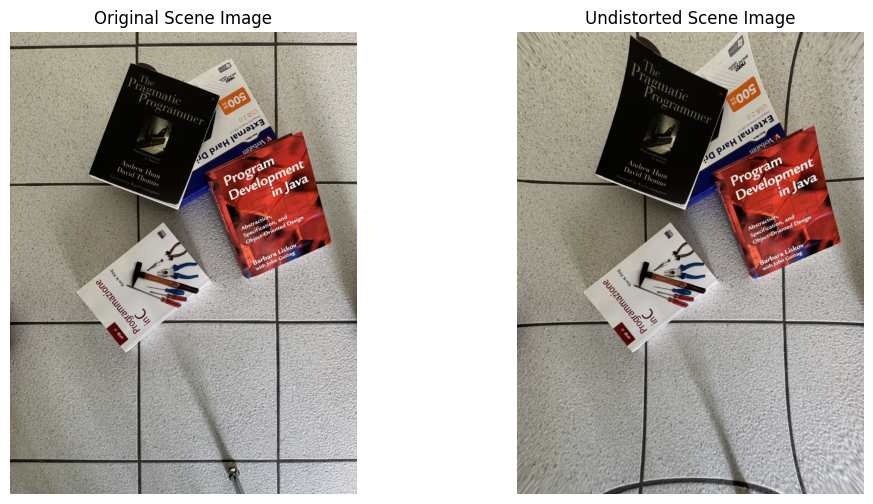

6. Undistorting the scene image with real distortion coefficients...
> Real Distortion Coefficients: [[ 0.0959633   0.12784815  0.00436388  0.00226419 -2.07290104]]



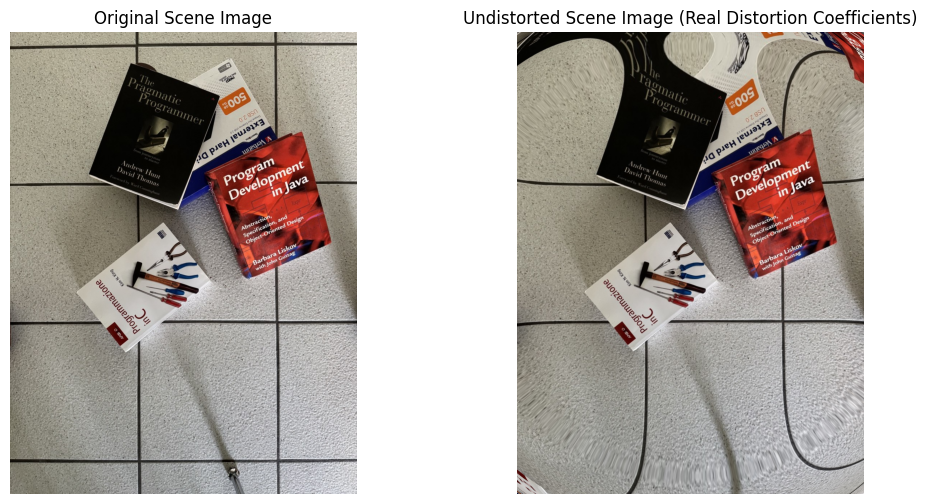

7. Analyzing the scene and computing distances...
8. Rendering results in the web visualizer...
Project root found: /home/stefano/projects/single-view-3d
  3D WEB VISUALIZATION GENERATOR

[1/5] Processing Template Poses
     ----------------------------------------
     | Generated 3 template meshes
     ----------------------------------------

[2/5] Creating Camera Visualization
     ----------------------------------------
     | Generated 4 line groups (axes + frustum)
     ----------------------------------------

[3/5] Loading HTML Template
     ----------------------------------------
     | Template loaded successfully
     ----------------------------------------

[4/5] Substituting Data Placeholders
     ----------------------------------------
     | Data integration complete
     ----------------------------------------

[5/5] Saving Visualization
     ----------------------------------------
     | File saved successfully
     ----------------------------------------

  VI

/usr/bin/xdg-open: 882: x-www-browser: not found
/usr/bin/xdg-open: 882: firefox: not found
/usr/bin/xdg-open: 882: iceweasel: not found
/usr/bin/xdg-open: 882: seamonkey: not found
/usr/bin/xdg-open: 882: mozilla: not found
/usr/bin/xdg-open: 882: epiphany: not found
/usr/bin/xdg-open: 882: konqueror: not found
/usr/bin/xdg-open: 882: chromium: not found
/usr/bin/xdg-open: 882: chromium-browser: not found
/usr/bin/xdg-open: 882: google-chrome: not found
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'http://localhost:8000/web/viewer.html'
127.0.0.1 - - [05/Aug/2025 11:44:23] "GET /web/viewer.html HTTP/1.1" 200 -


In [ ]:
# Run the pipeline for a specific scene
scene_id = "S12"
run_pipeline(data, scene_id)